# A case study in screening for new enzymatic reactions

In this example, we show how to search the KEGG database for a reaction of interest based on user requirements. At specific points we highlight how our code could be used for arbitrary molecules that the user is interested in. This is crucial because the KEGG database is not exhaustive, and we only accessed a portion of the database that has no ambiguities (to avoid the need for manual filtering).

Requirements to run this script:
* rdkit (2019.09.2.0)
* matplotlib (3.1.1)
* numpy (1.17.4)
* enzyme_screen
    * Clone source code and run this notebook in its default directory.

# This notebook requires data from screening, which is not uploaded!

## The idea:

We want to screen all collected reactions for a reaction that fits these constraints (automatic or manual application is noted):

1. Maximum component size within 5-7 Angstrom (automatic)
2. *One* component on *one* side of the reaction contains a nitrile group (automatic)
3. Value added from reactant to product (partially manual) e.g.:
    - cost of the reactants being much less than the products
    - products being unpurchasable and reactants being purchasable

Constraint *2* affords potential reaction monitoring through the isolated FT-IR signal of the nitrile group.

Constraint *3* is vague, but generally aims to determine some value-added by using an enzyme for a given reaction. This is often based on overcoming the cost of purchasing/synthesising the product through some non-enzymatic pathway by using an encapsulate enzyme. In this case, we use the primary literature on a selected reaction and some intuition to guide our efforts (i.e. we select a reaction (directionality determined from KEGG) where a relatively cheap (fair assumption) amino acid is the reactant). 

The alternative to this process would be to select a target reactant or product and search all reactions that include that target and apply similar constraints to test the validity of those reactions.

### Provide directory to reaction data and molecule data, and parameter file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

reaction_dir = (
    '/data/atarzia/projects/psp_phd/production/rxn_collection'
)
molecule_dir = (
    '/data/atarzia/projects/psp_phd/molecules/molecule_DBs/production'
)

# Handle import directories.
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities
param_file = '../data/param_file.txt'
params = utilities.read_params(param_file)

---------------------------------------------------------
run parameters:
VDW scale: 0.9
Box Margin: 4.0 Angstrom
Grid spacing: 0.5 Angstrom
show VDW?: False
Plot Ellipsoid?: False
No Conformers: 100.0
MW threshold: 500.0 g/mol
pI threshold: 6.0
Diffusion threshold: 4.2 Angstrom
DBs: KEGG
---------------------------------------------------------


### Find reaction systems with max component sizes within threshold

Using a threshold of 5 to 7 angstrom.

Results in a plot of reaction distributions.

In [2]:
import plotting_fn as pfn

In [3]:
threshold_min = 5
threshold_max = 7

In [4]:
# Read in reaction collection CSV: rs_properties.csv 
# from running RS_analysis.py.
rs_properties = pd.read_csv(
    os.path.join(reaction_dir, 'rs_properties.csv')
)
rs_within_threshold = rs_properties[
    rs_properties['max_mid_diam'] < threshold_max
]
rs_within_threshold = rs_within_threshold[
    rs_within_threshold['max_mid_diam'] >= threshold_min
]

In [5]:
print(f'{len(rs_within_threshold)} reactions in threshold')

989 reactions in threshold


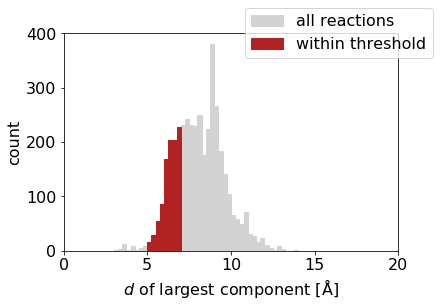

In [29]:
fig, ax = plt.subplots()

alpha = 1.0
width = 0.25
X_bins = np.arange(0, 20, width)

# All reactions.
hist, bin_edges = np.histogram(
    a=list(rs_properties['max_mid_diam']), 
    bins=X_bins
)
ax.bar(
    bin_edges[:-1],
    hist,
    align='edge',
    alpha=alpha,
    width=width,
    color='lightgray',
    edgecolor='lightgray',
    label='all reactions'
)

# Within threshold.
hist, bin_edges = np.histogram(
    a=list(rs_within_threshold['max_mid_diam']), 
    bins=X_bins
)
ax.bar(
    bin_edges[:-1],
    hist,
    align='edge',
    alpha=alpha,
    width=width,
    color='firebrick',
    edgecolor='firebrick',
    label='within threshold'
)

pfn.define_standard_plot(
    ax,
    xtitle='$d$ of largest component [$\mathrm{\AA}$]',
    ytitle='count',
    xlim=(0, 20),
    ylim=None
)
fig.legend(fontsize=16)
fig.savefig(
    os.path.join(reaction_dir, 'screen_example_distribution.pdf'),
    dpi=720,
    bbox_inches='tight'
)

plt.show()

### Find reaction systems with at least one nitrile functionality on one side of the reaction

In [7]:
import reaction

In [8]:
from rdkit.Chem import AllChem as rdkit
from rdkit.Chem import Fragments
# Handle some warnings for flat molecules.
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 
# Needed to show molecules
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 

def has_nitrile(mol_file):
    """
    Returns False if nitrile fragment is not found using RDKIT.

    """

    mol = rdkit.MolFromMolFile(mol_file)
    no_frag = Fragments.fr_nitrile(mol)
    if no_frag > 0:
        return True
    else:
        return False

RDKit WARNING: [21:33:05] Enabling RDKit 2019.09.2 jupyter extensions


In [9]:
# Define generator over reactions.
generator = reaction.yield_rxn_syst(
    output_dir=reaction_dir, 
    pars=params,
)

# Iterate over reactions, checking for validity.
target_reaction_ids = []
molecules_with_nitriles = []
for i, (count, rs) in enumerate(generator):
    if 'KEGG' not in rs.pkl:
        continue
    if rs.skip_rxn:
        continue
    if rs.components is None:
        continue
    
    # Check components for nitrile groups.
    reactants_w_nitriles = 0
    products_w_nitriles = 0
    for m in rs.components:
        mol_file = os.path.join(
            molecule_dir,
            m.name+'_opt.mol'
        )
        if has_nitrile(mol_file):
            if mol_file not in molecules_with_nitriles:
                molecules_with_nitriles.append(mol_file)
            if m.role == 'reactant':
                reactants_w_nitriles += 1
            elif m.role == 'product':
                products_w_nitriles += 1

    # Get both directions.
    if products_w_nitriles == 1 and reactants_w_nitriles == 0:
        target_reaction_ids.append(rs.DB_ID)
    if products_w_nitriles == 0 and reactants_w_nitriles == 1:
        target_reaction_ids.append(rs.DB_ID)

###  Draw nitrile containing molecules

In [10]:
print(
    f'There are {len(molecules_with_nitriles)} molecules '
    f'with nitrile groups, corresponding to '
    f'{len(target_reaction_ids)} reactions '
    'out of all.'
)

There are 40 molecules with nitrile groups, corresponding to 35 reactions out of all.


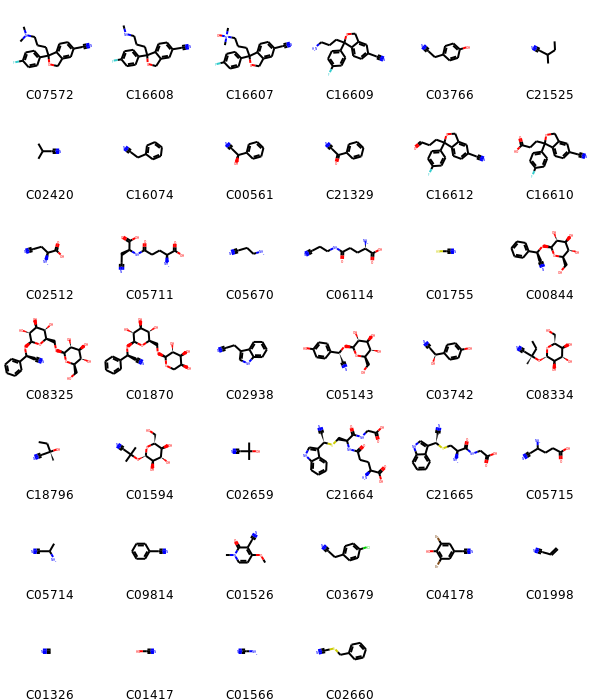

In [11]:
molecules = [
    rdkit.MolFromSmiles(rdkit.MolToSmiles(rdkit.MolFromMolFile(i)))
    for i in molecules_with_nitriles
]
mol_names = [
    i.replace(molecule_dir+'/', '').replace('_opt.mol', '')
    for i in molecules_with_nitriles
]

img = Draw.MolsToGridImage(
    molecules,
    molsPerRow=6,
    subImgSize=(100, 100),
    legends=mol_names,
)
img

## Update dataframe to have target reaction ids only.

In [12]:
target_reactions = rs_within_threshold[
    rs_within_threshold['db_id'].isin(target_reaction_ids)
]

In [13]:
print(
    f'There are {len(target_reactions)} reactions '
    'that fit all constraints so far.'
)

There are 19 reactions that fit all constraints so far.


In [14]:
target_reactions

,db_id,ec,max_mid_diam,minlogs,maxlogs,minlogp,maxlogp,deltasa,rmaxsa,pmaxsa,nr,np,PC_class,deltabct,rmaxbct,pmaxbct
342,R04306,1.14.14.37,6.600227,-1.998586,-1.998586,1.39470,1.39470,3.394732,2.473745,5.868477,1,2,1,4.181355,240.773900,244.955256
349,R11639,1.14.14.41,6.211105,-1.507822,-1.507822,1.49250,1.49250,1.948750,3.919727,5.868477,1,2,3,-0.271573,61.100494,60.828921
350,R11641,1.14.14.41,6.003429,-1.129174,-1.129174,1.10240,1.10240,2.414980,3.453497,5.868477,1,2,1,-0.351260,49.509775,49.158515
353,R07638,1.14.14.44,6.760399,-2.134369,-2.134369,1.68910,1.68910,3.639082,2.229395,5.868477,1,2,1,2.001894,205.757393,207.759287
1543,R01931,2.8.1.1,5.556896,0.005320,0.005320,-0.66390,-0.66390,-1.356926,5.247906,3.890980,2,2,4,-61.796808,88.061471,26.264663
2155,R01887,3.5.5.1,6.393847,-0.354919,-0.151544,-0.73690,-0.29792,0.799338,5.868477,6.667815,2,2,4,6.199731,138.383646,144.583377
2157,R03542,3.5.5.1,5.938465,-0.096464,0.106911,-0.58180,-0.14282,0.799338,5.868477,6.667815,2,2,4,9.409910,50.403628,59.813538
2158,R05591,3.5.5.1,6.931020,-1.896262,-1.854281,1.38480,1.55828,0.799338,5.868477,6.667815,2,2,1,8.039100,195.376853,203.415953
2159,R07855,3.5.5.1,6.946018,-2.094244,-1.862453,1.31370,1.75268,0.799338,5.868477,6.667815,2,2,1,8.199731,207.759287,215.959017
2161,R00486,3.5.5.4,6.314666,0.023730,0.227104,-1.12700,-0.68802,0.799338,5.868477,6.667815,2,2,1,6.039100,126.490225,132.529325


## Select reaction based on bertzCT and SAScore, plus intuition from visualisation

Plotting the measures of reaction productivity is useful, but so is looking manually through the small subset.

Both methods highlight R02846 (https://www.genome.jp/dbget-bin/www_bget?rn:R02846) as a good candidate:

- High deltaSA and deltaBertzCT
- The main reactant is a natural amino acid (cysteine). Note that the chirality is not defined in this specific KEGG Reaction, however, the chirality is defined as L-cysteine in the Enzyme entry (https://www.genome.jp/dbget-bin/www_bget?ec:4.4.1.9)

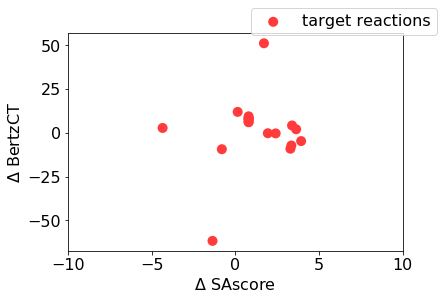

In [22]:
fig, ax = plt.subplots()

ax.scatter(
    target_reactions['deltasa'], 
    target_reactions['deltabct'],
    alpha=1.0,
    c='#ff3b3b',
    edgecolor='none',
    label='target reactions',
    s=100,
)

pfn.define_standard_plot(
    ax,
    xtitle=r'$\Delta$ SAscore',
    ytitle=r'$\Delta$ BertzCT',
    xlim=(-10, 10),
    ylim=None,
)
fig.legend(fontsize=16)
fig.savefig(
    os.path.join(
        reaction_dir, 
        'screen_example_complexity_targets.pdf'
    ),
    dpi=720,
    bbox_inches='tight'
)

plt.show()

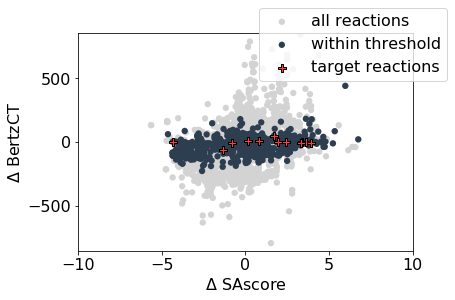

In [28]:
fig, ax = plt.subplots()

ax.scatter(
    rs_properties['deltasa'], 
    rs_properties['deltabct'],
    alpha=1.0,
    c='lightgray',
    edgecolor='none',
    label='all reactions',
    s=40,
)
ax.scatter(
    rs_within_threshold['deltasa'], 
    rs_within_threshold['deltabct'],
    alpha=1.0,
    c='#2c3e50',
    edgecolor='none',
    label='within threshold',
    s=40,
)
ax.scatter(
    target_reactions['deltasa'], 
    target_reactions['deltabct'],
    alpha=1.0,
    c='#ff3b3b',
    edgecolor='k',
    label='target reactions',
    marker='P',
    s=60,
)

pfn.define_standard_plot(
    ax,
    xtitle=r'$\Delta$ SAscore',
    ytitle=r'$\Delta$ BertzCT',
    xlim=(-10, 10),
    ylim=(-850, 850),
)
fig.legend(fontsize=16)
fig.savefig(
    os.path.join(
        reaction_dir, 
        'screen_example_complexity_all.pdf'
    ),
    dpi=720,
    bbox_inches='tight'
)

plt.show()

## Visualise properties of chosen reaction

Reaction: R02846 (https://www.genome.jp/dbget-bin/www_bget?rn:R02846)

In [17]:
# Read in reaction system.
rs = reaction.get_RS(
    filename=os.path.join(
        reaction_dir, 'sRS-4_4_1_9-KEGG-R02846.gpkl'
    ),
    output_dir=reaction_dir,
    pars=params,
    verbose=True
)

# Print properties and collate components.
print(rs)
if rs.skip_rxn:
    print(f'>>> {rs.skip_reason}')

print(
    f'max intermediate diameter = {rs.max_min_mid_diam} angstrom'
)
print(
    f'deltaSA = {rs.delta_SA}'
)
print(
    f'deltaBertzCT = {rs.delta_bCT}'
)
print('--------------------------\n')
print('Components:')

# Output molecular components and their properties.
reacts = []
reactstr = []
prodstr = []
prods = []
for rsc in rs.components:
    prop_dict = rsc.read_prop_file()
    print(rsc)
    print(f"SA = {round(prop_dict['Synth_score'], 3)}")
    print(f"BertzCT = {round(prop_dict['bertzCT'], 3)}")
    print('\n')
    if rsc.role == 'product':
        prods.append(
            rdkit.MolFromMolFile(rsc.structure_file)
        )
        prodstr.append(f'{rsc.name}')
    if rsc.role == 'reactant':
        reacts.append(
            rdkit.MolFromMolFile(rsc.structure_file)
        )
        reactstr.append(f'{rsc.name}')


loading: sRS-4_4_1_9-KEGG-R02846.gpkl
KEGG_Reaction(EC=4.4.1.9, DB=KEGG, ID=R02846, pkl=sRS-4_4_1_9-KEGG-R02846.gpkl)
max intermediate diameter = 6.080380383824703 angstrom
deltaSA = 1.716078234896762
deltaBertzCT = 51.15506614568605
--------------------------

Components:
Molecule(name=C00736, role=reactant, DB=KEGG, ID=C00736)
SA = 2.979
BertzCT = 75.335


Molecule(name=C00177, role=reactant, DB=KEGG, ID=C00177)
SA = 5.248
BertzCT = 6.755


Molecule(name=C00283, role=product, DB=KEGG, ID=C00283)
SA = 6.964
BertzCT = 0


Molecule(name=C02512, role=product, DB=KEGG, ID=C02512)
SA = 3.243
BertzCT = 126.49




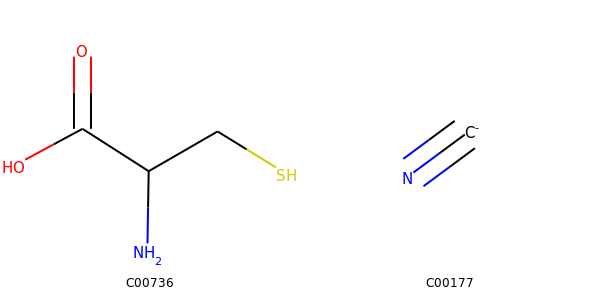

In [33]:
img = Draw.MolsToGridImage(
    reacts,
    molsPerRow=2,
    subImgSize=(300, 300),
    legends=reactstr,
)
img.save(
    os.path.join(
        reaction_dir, 
        'screen_example_reactants.png'
    )
)
img

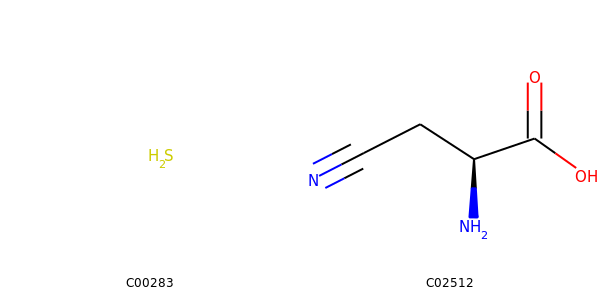

In [34]:
img = Draw.MolsToGridImage(
    prods,
    molsPerRow=2,
    subImgSize=(300, 300),
    legends=prodstr,
)
img.save(
    os.path.join(
        reaction_dir, 
        'screen_example_products.png'
    )
)
img

## Manually obtaining the cost of molecules

In this example, we will assume C00283 and C00177 are obtainable/purchasable through some means and that only C00736 and C02512 are relevant to the productivity of the reaction.

Note that the synthetic accessibility is 'large' for these molecules due to the two small molecules, while the change in BertzCT comes from the two larger molecules.

- Get CAS number from KEGG Compound pages:
    - KEGG: C00736, CAS: 3374-22-9
    - KEGG: C02512, CAS: 6232-19-5
- Use CAS number in some supplier website (using http://astatechinc.com/ here for no particular reason) 
    - KEGG: C00736, Price: \\$69 for 10 gram = \\$6.9 per gram
    - KEGG: C02512, Price: \\$309 for 1 gram = \\$309 per gram